In [55]:
# this notebook, we will train a MLP(Multi-Layer Perceptron) to reconize hand-written digit using Pytorch.
# import need library
import torch
import torchvision
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# check torch version
torch.__version__

'0.4.1'

In [56]:
# load the train dataset
dataset = pd.read_csv(r"input/train.csv",dtype = np.float32)
print(dataset.shape)
dataset.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
labels = dataset.label.values
# features all value in table except label
features = dataset.loc[:,dataset.columns != "label"].values
# print(features[0])
features = features/255 # normalization
# print(features[0])

# train test split. Size of train data is 80% and size of test data is 20%.
features_training, features_test, labels_training, label_test = train_test_split(features,
                                                                             labels,
                                                                             test_size = 0.2)

#print(type(features_training))
#print(type(labels_training))
#print(type(features_test))
#print(type(label_test))

#conver numpy array to torch tensor
featuresTraining = torch.from_numpy(features_training)
labelsTraining = torch.from_numpy(labels_training).type(torch.LongTensor)
featuresTest = torch.from_numpy(features_test)
labelTest = torch.from_numpy(label_test).type(torch.LongTensor)
#print(type(featuresTraining))
#print(type(labelsTraining))
#print(type(featuresTest))
#print(type(labelTest))

# batch_size
batch_size = 100

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTraining,labelsTraining)
test = torch.utils.data.TensorDataset(featuresTest,labelTest)
# Pytorch data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

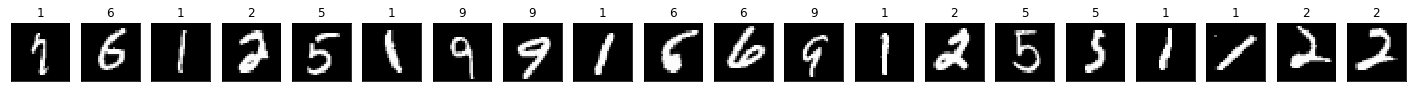

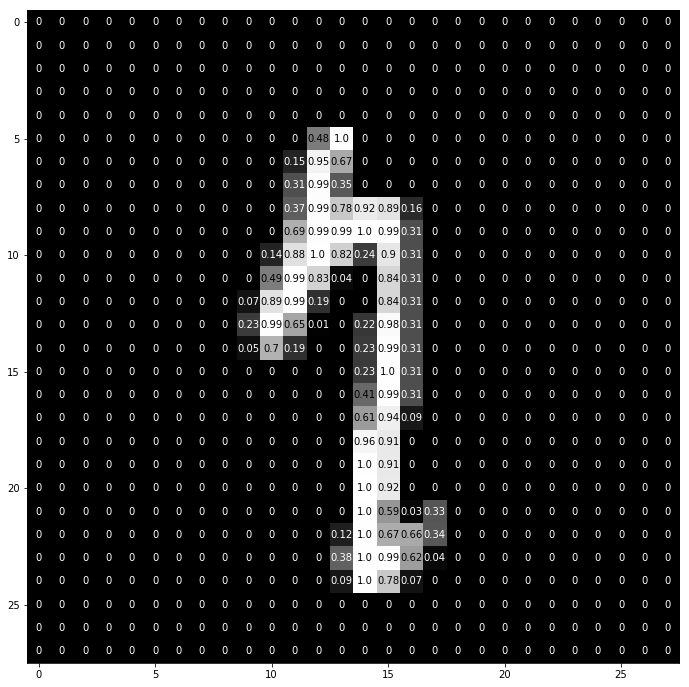

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray')
    ax.set_title(str(labels[idx].item()))

img = images[0].reshape(28,28)

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
#print(thresh)
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [125]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [126]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [127]:
# number of epochs to train the model
n_epochs = 100

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
             
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.190367
Epoch: 2 	Training Loss: 1.521425
Epoch: 3 	Training Loss: 0.822742
Epoch: 4 	Training Loss: 0.599969
Epoch: 5 	Training Loss: 0.504784
Epoch: 6 	Training Loss: 0.454189
Epoch: 7 	Training Loss: 0.419129
Epoch: 8 	Training Loss: 0.394467
Epoch: 9 	Training Loss: 0.369899
Epoch: 10 	Training Loss: 0.352823
Epoch: 11 	Training Loss: 0.339610
Epoch: 12 	Training Loss: 0.325646
Epoch: 13 	Training Loss: 0.317091
Epoch: 14 	Training Loss: 0.302085
Epoch: 15 	Training Loss: 0.295827
Epoch: 16 	Training Loss: 0.285106
Epoch: 17 	Training Loss: 0.276520
Epoch: 18 	Training Loss: 0.267528
Epoch: 19 	Training Loss: 0.258915
Epoch: 20 	Training Loss: 0.252695
Epoch: 21 	Training Loss: 0.244928
Epoch: 22 	Training Loss: 0.237465
Epoch: 23 	Training Loss: 0.230341
Epoch: 24 	Training Loss: 0.225010
Epoch: 25 	Training Loss: 0.219129
Epoch: 26 	Training Loss: 0.212846
Epoch: 27 	Training Loss: 0.207714
Epoch: 28 	Training Loss: 0.202316
Epoch: 29 	Training Loss: 0.1

In [128]:
# save model
torch.save(model.state_dict(), 'model.pt')
model.load_state_dict(torch.load('model.pt'))

In [129]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.097008

Test Accuracy of     0: 98% (855/868)
Test Accuracy of     1: 98% (939/951)
Test Accuracy of     2: 97% (833/856)
Test Accuracy of     3: 95% (796/836)
Test Accuracy of     4: 97% (796/817)
Test Accuracy of     5: 97% (685/703)
Test Accuracy of     6: 98% (799/811)
Test Accuracy of     7: 96% (839/873)
Test Accuracy of     8: 95% (798/836)
Test Accuracy of     9: 95% (814/849)

Test Accuracy (Overall): 97% (8154/8400)


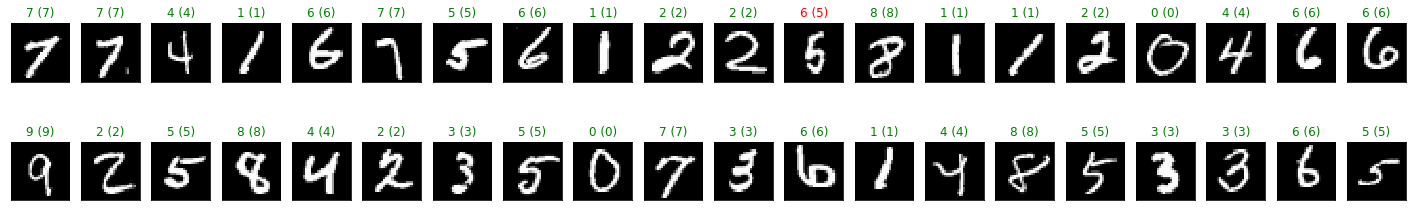

In [130]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(40):
    ax = fig.add_subplot(2, 40/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape(28,28), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))